## Description

This version is trained on LaFleur et al.'s base data. For X data, it onehot encodes base pairs in each element and appeneds them to a 2 dimensional array. It pads the whole sequence instead of each element. The y data is the 'Observed log(TX/Txref)' which is normalized using sklearn's MinMaxScaler (from 0, high expression to 1, low expression).

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load the Data

df = pd.read_csv('../Data/41467_2022_32829_MOESM5_ESM.csv')

In [3]:
# Normalize the y values

from sklearn.preprocessing import MinMaxScaler
df['Normalized Observed'] = MinMaxScaler().fit_transform(df[['Observed']])

In [4]:
# Concatenate the X values into a single string

X = df[['UP', 'h35', 'spacs', 'h10', 'disc', 'ITR']].astype(str).agg(''.join, axis=1)
y = df['Normalized Observed']

len(X[0])

74

In [5]:
X.shape

(13481,)

In [6]:
# Define the function to onehot encode the input (x) sequences

def padded_one_hot_encode(sequence):
    mapping = {'A': [1,0,0,0], 'C': [0,1,0,0], 'G': [0,0,1,0], 'T': [0,0,0,1], '0': [0,0,0,0]}
    encoding = []
    for nucleotide in sequence:
         encoding += [mapping[nucleotide]]
    return encoding

upstream_padding = []
max_length = max(len(subarray) for subarray in X)
for seq in X:
    zeros = '0' * (max_length-len(seq))
    upstream_padding += [padded_one_hot_encode(zeros + seq)]

X = np.array(upstream_padding)
X[0]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0,

In [7]:
print(max_length)

87


In [8]:
# Split the data into training and testing sets (80/20)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# Define CNN with kernal size of 4
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=X.shape[1:]))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=150, 
                    batch_size=32, 
                    validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)

results = loss
model_history = history
model.save('CNN_1_3_1.keras')


/Users/tien/Documents/GitHub/promoter-sequence-transcription-rates/Synth_CURE_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Epoch 1/150


/Users/tien/Documents/GitHub/promoter-sequence-transcription-rates/Synth_CURE_env/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0227 - val_loss: 0.0081
Epoch 2/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0079
Epoch 3/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 4/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 5/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - val_loss: 0.0088
Epoch 6/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 7/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 8/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 9/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 10/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 11/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 12/150
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [10]:
print(loss)

0.009642430581152439


In [11]:
# Load the model that was saved (for future use)

from keras.models import load_model

model = load_model('CNN_1_3_1.keras')

In [12]:
# Make predictions for the test set to visualize the results

predictions_array = model.predict(np.array(X))[:, 0]
predicted = pd.DataFrame(predictions_array, columns=['Value'])

observed = df['Normalized Observed'].values

422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


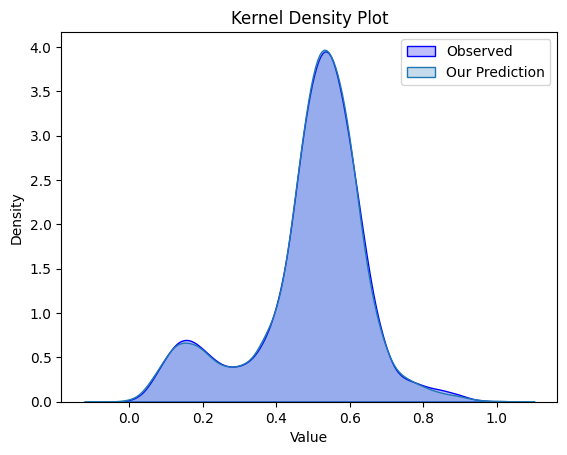

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(df['Normalized Observed'], fill=True, color='blue', label='Observed')
sns.kdeplot(predicted, fill=True, color='green', label='Our Prediction')

plt.title('Kernel Density Plot')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()


In [14]:
observed.shape

(13481,)

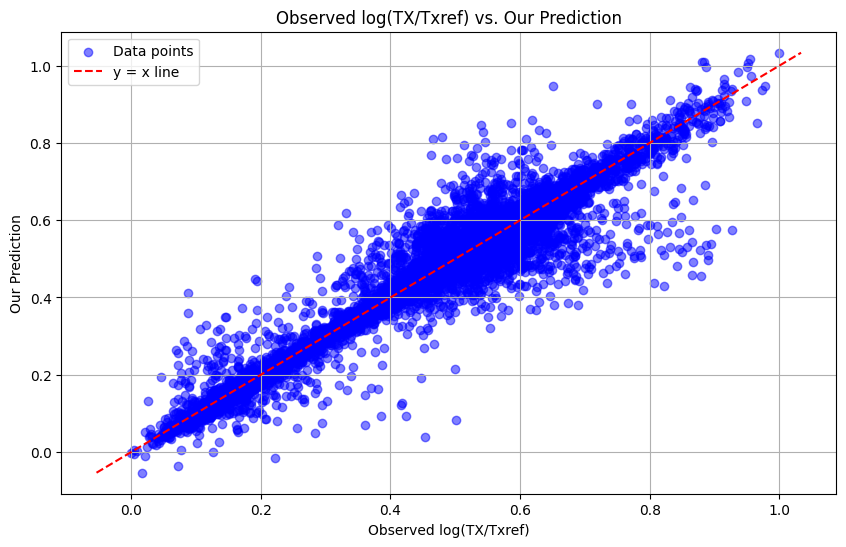

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `our_prediction` and `observed` are already defined
predicted = np.ravel(predicted)

plt.figure(figsize=(10, 6))
plt.scatter(observed, predicted, color='blue', alpha=0.5, label='Data points')

# Adding the y = x line
min_val = min(min(observed), min(predicted))
max_val = max(max(observed), max(predicted))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x line')

plt.title('Observed log(TX/Txref) vs. Our Prediction')
plt.xlabel('Observed log(TX/Txref)')
plt.ylabel('Our Prediction')
plt.legend()
plt.grid(True)
plt.show()


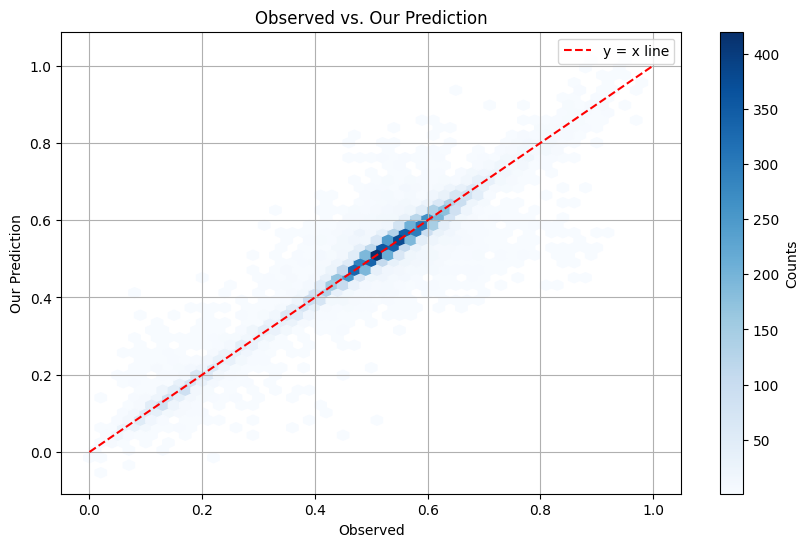

In [16]:
plt.figure(figsize=(10, 6))

# Hexbin plot
plt.hexbin(observed, predicted, gridsize=50, cmap='Blues', mincnt=1)

# Add color bar
plt.colorbar(label='Counts')

# Add y=x line
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y = x line')

plt.title('Observed vs. Our Prediction')
plt.xlabel('Observed')
plt.ylabel('Our Prediction')
plt.legend()
plt.grid(True)
plt.show()